In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
project_name = 'CAT-dcgan'

In [2]:
DATA_DIR = "D:\Programming\Python\AI\gan\images"

In [4]:
print(os.listdir(DATA_DIR))

['cats']


In [5]:
print(os.listdir(DATA_DIR+'/cats')[:10])

['8099.jpg', '13782.jpg', '11484.jpg', '958.jpg', '1684.jpg', '11357.jpg', '1153.jpg', '4886.jpg', '5661.jpg', '14054.jpg']


In [3]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [5]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

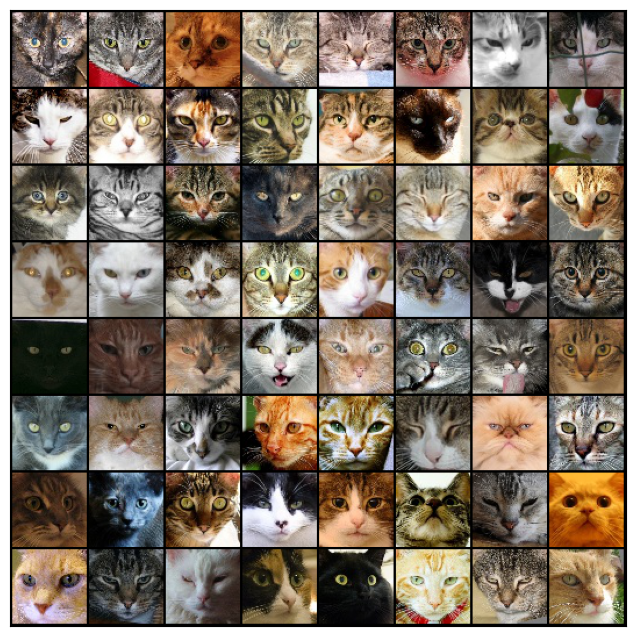

In [8]:
show_batch(train_dl)

In [11]:
!pip install jovian --upgrade --quiet

In [12]:
import jovian

<IPython.core.display.Javascript object>

In [38]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/shubham7169007/CAT-dcgan


<IPython.core.display.Javascript object>

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [13]:
discriminator = to_device(discriminator, device)

In [14]:
latent_size = 128

In [15]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


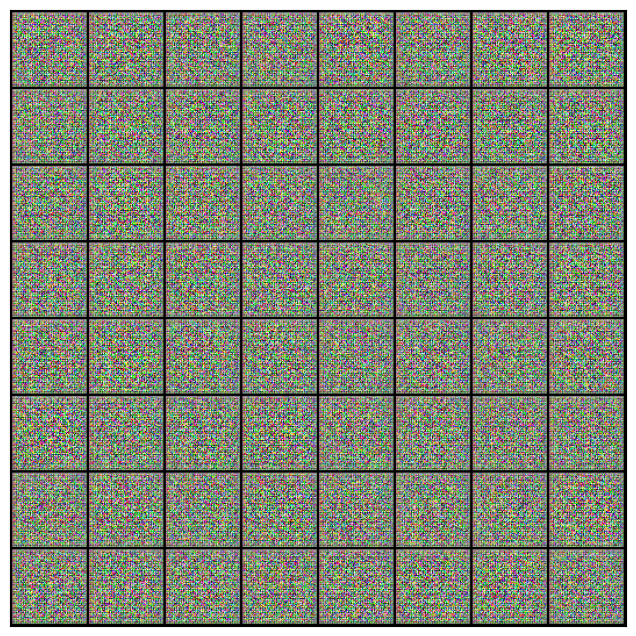

In [16]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [17]:
generator = to_device(generator, device)

In [18]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [19]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [23]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


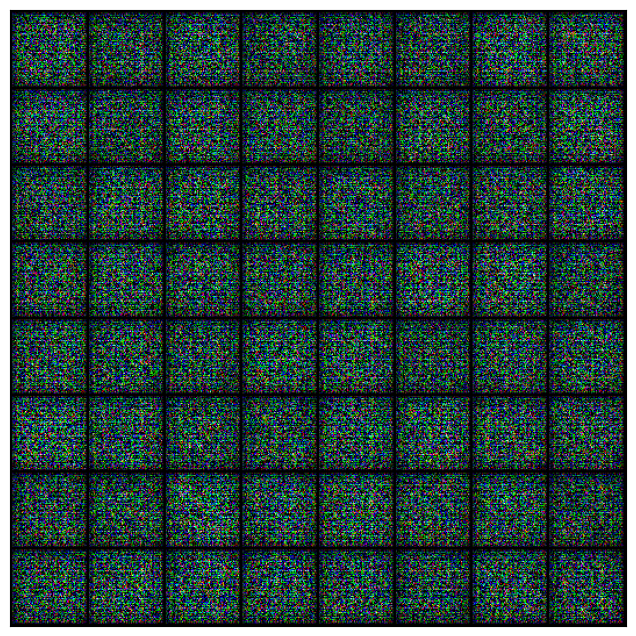

In [26]:
save_samples(0, fixed_latent)

In [27]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.0002
epochs = 60

In [29]:
history = fit(epochs, lr)

  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 4.4037, loss_d: 1.5491, real_score: 0.3385, fake_score: 0.0064
Saving generated-images-0001.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 7.3378, loss_d: 1.6603, real_score: 0.8210, fake_score: 0.6937
Saving generated-images-0002.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 5.2143, loss_d: 0.3501, real_score: 0.8504, fake_score: 0.1386
Saving generated-images-0003.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 4.6055, loss_d: 0.8636, real_score: 0.6944, fake_score: 0.3241
Saving generated-images-0004.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 5.1061, loss_d: 0.5841, real_score: 0.9369, fake_score: 0.3803
Saving generated-images-0005.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 1.6670, loss_d: 0.3194, real_score: 0.8071, fake_score: 0.0848
Saving generated-images-0006.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 4.8330, loss_d: 0.7132, real_score: 0.8213, fake_score: 0.3643
Saving generated-images-0007.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 2.3109, loss_d: 0.6839, real_score: 0.5523, fake_score: 0.0399
Saving generated-images-0008.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 7.4887, loss_d: 1.0664, real_score: 0.9461, fake_score: 0.6016
Saving generated-images-0009.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 7.6587, loss_d: 0.8754, real_score: 0.9907, fake_score: 0.5266
Saving generated-images-0010.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 4.1947, loss_d: 0.2604, real_score: 0.9729, fake_score: 0.1952
Saving generated-images-0011.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 2.4390, loss_d: 3.1929, real_score: 0.0503, fake_score: 0.0054
Saving generated-images-0012.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 6.6502, loss_d: 0.1688, real_score: 0.8546, fake_score: 0.0006
Saving generated-images-0013.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 5.1723, loss_d: 0.9823, real_score: 0.4569, fake_score: 0.0006
Saving generated-images-0014.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 0.9344, loss_d: 0.7723, real_score: 0.5786, fake_score: 0.0485
Saving generated-images-0015.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 8.5138, loss_d: 0.5717, real_score: 0.9967, fake_score: 0.4088
Saving generated-images-0016.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 4.7986, loss_d: 0.1716, real_score: 0.9912, fake_score: 0.1430
Saving generated-images-0017.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 6.3689, loss_d: 0.7758, real_score: 0.8499, fake_score: 0.3964
Saving generated-images-0018.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 4.0482, loss_d: 0.6697, real_score: 0.5550, fake_score: 0.0045
Saving generated-images-0019.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 1.9785, loss_d: 0.3348, real_score: 0.7720, fake_score: 0.0629
Saving generated-images-0020.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 5.2580, loss_d: 0.0598, real_score: 0.9985, fake_score: 0.0555
Saving generated-images-0021.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 6.5695, loss_d: 0.2741, real_score: 0.9975, fake_score: 0.2110
Saving generated-images-0022.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 5.6447, loss_d: 0.0270, real_score: 0.9805, fake_score: 0.0071
Saving generated-images-0023.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 4.8972, loss_d: 0.1109, real_score: 0.9773, fake_score: 0.0782
Saving generated-images-0024.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 6.2811, loss_d: 0.0316, real_score: 0.9736, fake_score: 0.0045
Saving generated-images-0025.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 3.4781, loss_d: 0.1265, real_score: 0.9705, fake_score: 0.0806
Saving generated-images-0026.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 5.4909, loss_d: 0.0420, real_score: 0.9645, fake_score: 0.0056
Saving generated-images-0027.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 2.9259, loss_d: 0.0835, real_score: 0.9389, fake_score: 0.0156
Saving generated-images-0028.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 5.3244, loss_d: 0.0584, real_score: 0.9465, fake_score: 0.0020
Saving generated-images-0029.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 3.5911, loss_d: 0.1486, real_score: 0.9012, fake_score: 0.0385
Saving generated-images-0030.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 2.7284, loss_d: 0.2235, real_score: 0.8823, fake_score: 0.0811
Saving generated-images-0031.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 4.3660, loss_d: 0.0802, real_score: 0.9364, fake_score: 0.0128
Saving generated-images-0032.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 8.1791, loss_d: 0.3804, real_score: 0.9393, fake_score: 0.2513
Saving generated-images-0033.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 3.9304, loss_d: 0.1021, real_score: 0.9248, fake_score: 0.0203
Saving generated-images-0034.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 8.7366, loss_d: 0.3643, real_score: 0.9999, fake_score: 0.2378
Saving generated-images-0035.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 15.8472, loss_d: 1.5578, real_score: 0.9972, fake_score: 0.7230
Saving generated-images-0036.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 7.7873, loss_d: 0.0035, real_score: 0.9985, fake_score: 0.0020
Saving generated-images-0037.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 3.1198, loss_d: 0.7296, real_score: 0.5034, fake_score: 0.0004
Saving generated-images-0038.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 8.2432, loss_d: 0.1521, real_score: 0.8741, fake_score: 0.0046
Saving generated-images-0039.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 3.7876, loss_d: 0.3292, real_score: 0.9006, fake_score: 0.1612
Saving generated-images-0040.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 5.7791, loss_d: 0.0411, real_score: 0.9632, fake_score: 0.0028
Saving generated-images-0041.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 5.9892, loss_d: 0.0711, real_score: 0.9363, fake_score: 0.0013
Saving generated-images-0042.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 1.0564, loss_d: 1.0510, real_score: 0.4544, fake_score: 0.0114
Saving generated-images-0043.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 4.3392, loss_d: 0.0245, real_score: 0.9933, fake_score: 0.0173
Saving generated-images-0044.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 3.3587, loss_d: 0.4567, real_score: 0.6523, fake_score: 0.0006
Saving generated-images-0045.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 5.4140, loss_d: 0.6791, real_score: 0.6828, fake_score: 0.0002
Saving generated-images-0046.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 12.3046, loss_d: 0.6828, real_score: 0.9957, fake_score: 0.3693
Saving generated-images-0047.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 5.8318, loss_d: 0.1042, real_score: 0.9969, fake_score: 0.0861
Saving generated-images-0048.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 4.1090, loss_d: 0.4352, real_score: 0.7656, fake_score: 0.0296
Saving generated-images-0049.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 6.3507, loss_d: 0.2140, real_score: 0.9554, fake_score: 0.1376
Saving generated-images-0050.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 4.0294, loss_d: 0.1947, real_score: 0.8385, fake_score: 0.0042
Saving generated-images-0051.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 6.3087, loss_d: 0.0845, real_score: 0.9219, fake_score: 0.0008
Saving generated-images-0052.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 12.4776, loss_d: 0.6535, real_score: 0.9908, fake_score: 0.4133
Saving generated-images-0053.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 6.7196, loss_d: 0.2580, real_score: 0.9760, fake_score: 0.1900
Saving generated-images-0054.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 6.5751, loss_d: 0.0095, real_score: 0.9957, fake_score: 0.0052
Saving generated-images-0055.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 9.8077, loss_d: 0.1410, real_score: 0.8774, fake_score: 0.0006
Saving generated-images-0056.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 5.0288, loss_d: 0.1450, real_score: 0.9956, fake_score: 0.1179
Saving generated-images-0057.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 5.8967, loss_d: 0.4229, real_score: 0.9918, fake_score: 0.2582
Saving generated-images-0058.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 2.0631, loss_d: 0.3176, real_score: 0.7786, fake_score: 0.0470
Saving generated-images-0059.png


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 2.8447, loss_d: 0.3668, real_score: 0.7496, fake_score: 0.0372
Saving generated-images-0060.png


In [31]:
losses_g, losses_d, real_scores, fake_scores = history

In [31]:
from IPython.display import Image

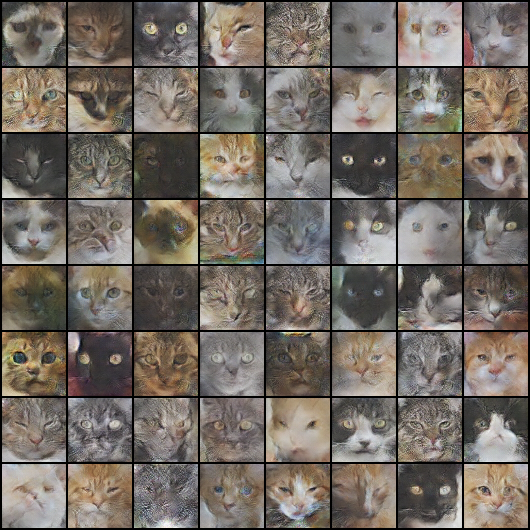

In [32]:
Image('./generated/generated-images-0060.png')

In [34]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

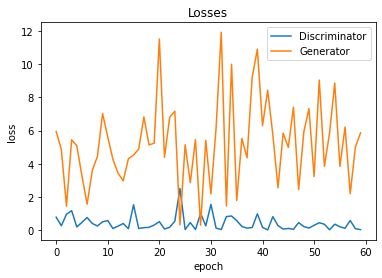

In [35]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

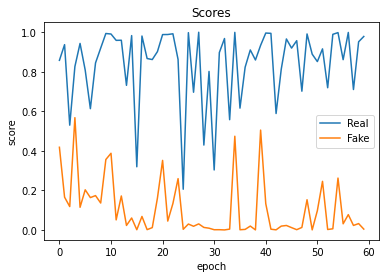

In [36]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');